단뱡항 LSTM으로 텍스트 분류를 수행할 수도 있지만 때로는 양방향 LSTM을 사용하는 것이 더 강력합니다. 여기에 추가적으로 어텐션 메커니즘을 사용할 수도 있습니다. 양방향 LSTM과 어텐션 메커니즘으로 IMDB 리뷰 감성 분류하기를 수행해봅시다.

# 1. IMDB 리뷰 데이터 전처리하기

In [1]:
from tensorflow.keras.datasets import imdb
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences

IMDB 리뷰 데이터는 앞서 텍스트 분류하기 챕터에서 다룬 바 있으므로 데이터에 대한 상세 설명은 생략합니다. 최대 단어 개수를 10,000으로 제한하고 훈련 데이터와 테스트 데이터를 받아옵니다.

In [2]:
vocab_size = 10000
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words = vocab_size)

17464789/17464789 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


훈련 데이터와 이에 대한 레이블이 각각 X_train, y_train에 테스트 데이터와 이에 대한 레이블이 각각 X_test, y_test에 저장되었습니다. IMDB 리뷰 데이터는 이미 정수 인코딩이 된 상태므로 남은 전처리는 패딩뿐입니다. 리뷰의 최대 길이와 평균 길이를 확인해봅시다.

In [3]:
print('리뷰의 최대 길이 : {}'.format(max(len(I) for I in X_train)))
print('리뷰의 평균 길이 : {}'.format(sum(map(len, X_train))/len(X_train)))

리뷰의 최대 길이 : 2494
리뷰의 평균 길이 : 238.71364


리뷰의 최대 길이는 2,494이며 리뷰의 평균 길이는 약 238로 확인됩니다. 평균 길이보다는 조금 크게 데이터를 패딩하겠습니다.

In [4]:
max_len = 500
X_train = pad_sequences(X_train, maxlen = max_len)
X_test = pad_sequences(X_test, maxlen = max_len)

# 2. 바다나우 어텐션(Bahdanau Attention)
여기서 사용할 어텐션은 바다나우 어텐션(Bahdanau attention)입니다. 이를 이해하기 위해 앞서 배운 가장 쉬운 어텐션이었던 닷 프로덕트 어텐션과 어텐션 스코어 함수의 정의를 상기해봅시다.

어텐션 스코어 함수란 주어진 query와 모든 key에 대해서 유사도를 측정하는 함수를 말합니다. 그리고 닷 프로덕트 어텐션에서는 query와 key의 유사도를 구하는 방법이 내적(dot product)이었습니다. 다음은 닷 프로덕트 어텐션의 어텐션 스코어 함수를 보여줍니다.

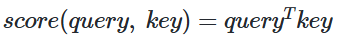

바다나우 어텐션은 아래와 같은 어텐션 스코어 함수를 사용합니다.

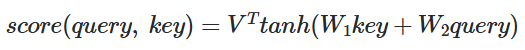

이 어텐션 스코어 함수를 사용하여 어텐션 메커니즘을 구현하면 됩니다. 그런데 텍스트 분류에서 어텐션 메커니즘을 사용하는 이유는 무엇일까요? RNN의 마지막 은닉 상태는 예측을 위해 사용됩니다. 그런데 이 RNN의 마지막 은닉 상태는 몇 가지 유용한 정보들을 손실한 상태입니다. 그래서 RNN이 time step을 지나며 손실했던 정보들을 다시 참고하고자 합니다.

이는 다시 말해 RNN의 모든 은닉 상태들을 다시 한 번 참고하겠다는 것입니다. 그리고 이를 위해서 어텐션메커니즘을 사용합니다.

In [5]:
import tensorflow as tf

In [6]:
class BahdanauAttention(tf.keras.Model):
  def __init__(self, units):
    super(BahdanauAttention, self).__init__()
    self.W1 = Dense(units)
    self.W2 = Dense(units)
    self.V = Dense(1)

  def call(self, values, query): # 단, key와 value는 같음
    # query shape == (batch_size, hidden size)
    # hidden_with_axis shape == (batch_size, 1, hidden size)
    # score 계산을 위해 뒤에서 할 덧셈을 위해서 차원을 변경해줍니다.
    hidden_with_time_axis = tf.expand_dims(query, 1)


    # score shape == (batch_size, max_length, 1)
    # we get 1 at the last axis because we are applying score to self.V
    # the shape of the tensor before applying self.V is (batch_size, max_length, units)

    score = self.V(tf.nn.tanh(
        self.W1(values) + self.W2(hidden_with_time_axis)
    ))

    # attention_weights shape == (batch_size, max_length, 1)
    attention_weights = tf.nn.softmax(score, axis=1)

    # context_vector shape after sum == (batch_size, hidden_size)
    context_vector = attention_weights * values
    context_vector = tf.reduce_sum(context_vector, axis=1)

    return context_vector, attention_weights

# 3. 양방향 LSTM + 어텐션 메커니즘(BiLSTM with Attention Mechanism)


In [7]:
from tensorflow.keras.layers import Dense, Embedding, Bidirectional, LSTM, Concatenate, Dropout
from tensorflow.keras import Input, Model
from tensorflow.keras import optimizers
import os

In [9]:
# 모델 설계
# 입력층과 임베딩층
sequence_input = Input(shape=(max_len,), dtype='int32')
embedded_sequences = Embedding(vocab_size, 128, input_length=max_len, mask_zero = True)(sequence_input)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


10,000개의 단어들을 128차원의 벡터로 임베딩하도록 설계하였습니다. 이제 양방향 LSTM을 설계합니다. 단, 여기서는 양방향 LSTM을 두 층을 사용하겠습니다. 우선, 첫번째 층입니다. 두번째 층을 위에 쌓을 예정이므로 return_sequences를 True로 해주어야 합니다.

In [10]:
lstm = Bidirectional(LSTM(64, dropout=0.5, return_sequences = True))(embedded_sequences)

두번째 층을 설계합니다. 상태를 리턴받아야 하므로 return_state를 True로 해주어야 합니다.

In [11]:
lstm, forward_h, forward_c, backward_h, backward_c = Bidirectional \
  (LSTM(64, dropout=0.5, return_sequences=True, return_state=True))(lstm)

각 상태의 크기(shape)를 출력해보겠습니다.

In [13]:
print(lstm.shape, forward_h.shape, forward_c.shape, backward_h.shape, backward_c.shape)

(None, 500, 128) (None, 64) (None, 64) (None, 64) (None, 64)


순방향 LSTM의 은닉 상태와 셀상태를 forward_h, forward_c에 저장하고, 역방향 LSTM의 은닉 상태와 셀 상태를 backward_h, backward_c에 저장합니다.

각 은닉 상태나 셀 상태의 경우에는 128차원을 가지는데, lstm의 경우에는 (500 × 128)의 크기를 가집니다. foward 방향과 backward 방향이 연결된 hidden state벡터가 모든 시점에 대해서 존재함을 의미합니다.

양방향 LSTM을 사용할 경우에는 순방향 LSTM과 역방향 LSTM 각각 은닉 상태와 셀 상태를 가지므로, 양방향 LSTM의 은닉 상태와 셀 상태를 사용하려면 두 방향의 LSTM의 상태들을 연결(concatenate)해주면 됩니다.

In [14]:
state_h = Concatenate()([forward_h, backward_h]) # 은닉 상태
state_c = Concatenate()([forward_c, backward_c]) # 셀 상태

어텐션 메커니즘에서는 은닉 상태를 사용합니다. 이를 입력으로 컨텍스트 벡터(context vector)를 얻습니다.

In [15]:
attention = BahdanauAttention(64) # 가중치 크기 정의
context_vector, attention_weights = attention(lstm, state_h)

/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'bahdanau_attention' (of type BahdanauAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


컨텍스트 벡터를 밀집층(dense layer)에 통과시키고, 이진 분류이므로 최종 출력층에 1개의 뉴런을 배치하고, 활성화 함수로 시그모이드 함수를 사용합니다.

In [16]:
dense1 = Dense(20, activation="relu")(context_vector)
dropout = Dropout(0.5)(dense1)
output = Dense(1, activation="sigmoid")(dropout)
model = Model(inputs=sequence_input, outputs=output)

옵티마이저로 아담 옵티마이저 사용하고, 모델을 컴파일합니다.

In [17]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

시그모이드 함수를 사용하므로 손실 함수로 binary_crossentropy를 사용하였습니다. 이제 모델을 훈련하겠습니다.

In [18]:
history = model.fit(X_train, y_train, epochs=3, batch_size=256, validation_data=(X_test, y_test), verbose=1)

Epoch 1/3


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:915: UserWarning: Layer 'bahdanau_attention' (of type BahdanauAttention) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


98/98 ━━━━━━━━━━━━━━━━━━━━ 1215s 12s/step - accuracy: 0.6407 - loss: 0.6126 - val_accuracy: 0.8554 - val_loss: 0.3355
Epoch 2/3
98/98 ━━━━━━━━━━━━━━━━━━━━ 1207s 12s/step - accuracy: 0.8965 - loss: 0.2897 - val_accuracy: 0.8660 - val_loss: 0.3057
Epoch 3/3
98/98 ━━━━━━━━━━━━━━━━━━━━ 1280s 13s/step - accuracy: 0.9300 - loss: 0.2149 - val_accuracy: 0.8572 - val_loss: 0.3425


검증 데이터로 테스트 데이터를 사용하여 에포크가 끝날 때마다 테스트 데이터에 대한 정확도를 출력하도록 하였습니다.

In [19]:
print("\n 테스트 정확도: %.4f" % (model.evaluate(X_test, y_test)[1]))

782/782 ━━━━━━━━━━━━━━━━━━━━ 321s 411ms/step - accuracy: 0.8572 - loss: 0.3468

 테스트 정확도: 0.8572
